In [83]:
import pprint
import collections
import os
import re

In [84]:
import string
import time

import graphviz
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pydot
from keras.callbacks import EarlyStopping
from keras.layers import (LSTM, Convolution1D, Dense, Dropout, Embedding,
                          Flatten, GlobalMaxPooling1D, MaxPooling1D,
                          SpatialDropout1D, concatenate)
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model

stopping_words = set(stopwords.words('english'))




lemmatizer_wordnet = WordNetLemmatizer()


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [85]:
start = time.time()

data = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")

In [86]:
t_tweets = data['text']

# Data Exploration

In [87]:
t_tweets

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [88]:

data.sample(100)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4043,567853644420423680,negative,1.0000,Customer Service Issue,1.0000,United,NaN,_Ana_Paulina,NaN,0,@united is amazing how hard is to talk with cu...,NaN,2015-02-17 17:10:33 -0800,NaN,Guadalajara
4172,567794720425144321,negative,1.0000,Customer Service Issue,1.0000,United,NaN,k8slo,NaN,0,@United Your customer service for Mileage Plus...,NaN,2015-02-17 13:16:25 -0800,Washington DC,Eastern Time (US & Canada)
13491,569850239789568000,negative,1.0000,Customer Service Issue,1.0000,American,NaN,theseanodell,NaN,0,@malhoit at least you got a response from @Ame...,NaN,2015-02-23 05:24:19 -0800,Texas,Central Time (US & Canada)
7873,569138202424025088,negative,1.0000,Late Flight,1.0000,Delta,NaN,alexlmichael,NaN,0,@JetBlue you #fail. Snow coming to DC area. Tr...,NaN,2015-02-21 06:14:56 -0800,Washington DC,Eastern Time (US & Canada)
13251,569906117100351493,negative,1.0000,Customer Service Issue,1.0000,American,NaN,Bank1960,NaN,0,"@AmericanAir So much for Status, EP and 1.5 mi...",NaN,2015-02-23 09:06:21 -0800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,568176529584173056,negative,1.0000,Bad Flight,1.0000,Southwest,NaN,FMLBROOKLYN,NaN,0,@SouthwestAir your WiFi is shit. fix that up b...,NaN,2015-02-18 14:33:35 -0800,NaN,Arizona
8549,568173309747048448,positive,1.0000,NaN,NaN,Delta,NaN,nonprofitnicole,NaN,0,@JetBlue What a great idea! #cometoAustin,NaN,2015-02-18 14:20:47 -0800,"Austin, Texas",Central Time (US & Canada)
8255,568554411078889473,negative,1.0000,Can't Tell,0.3548,Delta,NaN,MsBooya,NaN,0,@JetBlue I don't want to seem crazy! Have alre...,NaN,2015-02-19 15:35:09 -0800,NaN,NaN
10505,569244957698969602,negative,1.0000,Lost Luggage,0.6759,US Airways,NaN,LindsaySweeting,NaN,0,@USAirways Your Baggage system has hung up on ...,NaN,2015-02-21 13:19:08 -0800,"Asheville, NC",Central Time (US & Canada)


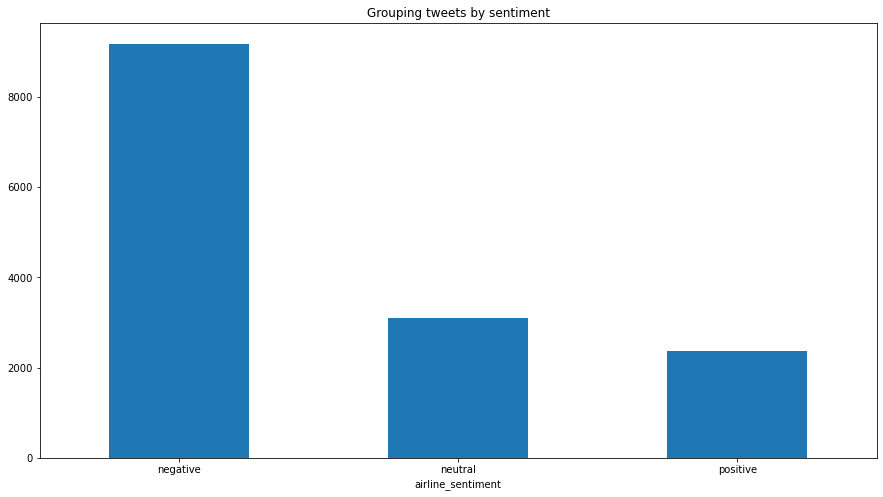

In [89]:

tweet_sentiment_group = data.groupby(['airline_sentiment']).count()
tweet_sentiment_group.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Grouping tweets by sentiment', y='tweet_id');

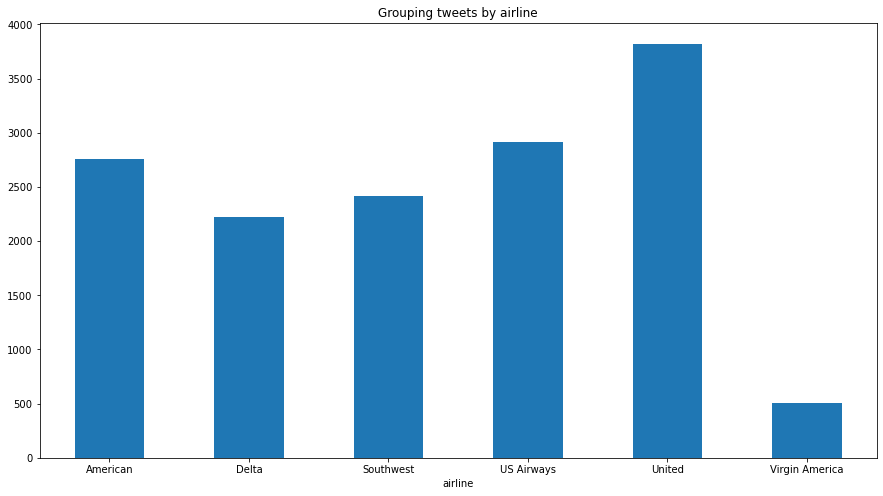

In [90]:

tweet_airline_group = data.groupby(['airline']).count()
tweet_airline_group.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Grouping tweets by airline', y='tweet_id');

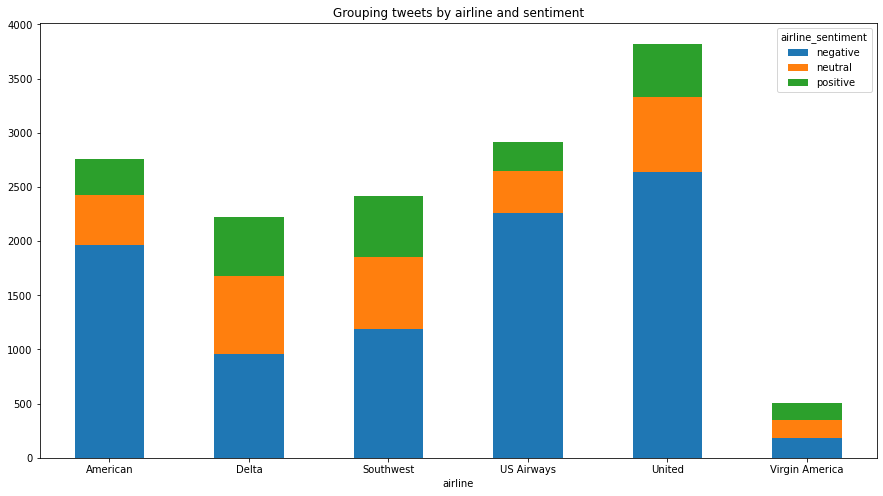

In [91]:
groupedByAirline = data.groupby(['airline', 'airline_sentiment']).count().unstack()
groupedByAirline.plot(kind='bar', figsize=(15, 8), rot=0, stacked=True,  title='Grouping tweets by airline and sentiment', y='tweet_id');

In [92]:

reasons_tweet = data[['airline','negativereason']]
tweet_reason_group = reasons_tweet.groupby('negativereason', as_index=False).count()
tweet_reason_group.sort_values('airline', ascending=False)

,negativereason,airline
3,Customer Service Issue,2910
7,Late Flight,1665
1,Can't Tell,1190
2,Cancelled Flight,847
8,Lost Luggage,724
0,Bad Flight,580
6,Flight Booking Problems,529
5,Flight Attendant Complaints,481
9,longlines,178
4,Damaged Luggage,74


# Preprocess

In [93]:
def preprocess(t_tweet):

    # "@user"
    t_tweet = re.sub('@[\w]*',"",t_tweet)

    # URLs
    t_tweet  = re.sub('((www\.[\S]+)|(https?://[\S]+))',"",t_tweet)

    # Letters Only
    t_tweet = re.sub('[^a-zA-Z\s]'," ", t_tweet)
    t_tweet = re.sub('\s[a-zA-z]\s'," ", t_tweet)

    # lowercase
    t_tweet = t_tweet.lower()

    #tokens
    t_tweet = word_tokenize(t_tweet)

    #stopwords
    t_tweet = list(filter(lambda l: l not in stopping_words, t_tweet))

    t_tweet = [lemmatizer_wordnet.lemmatize(word) for word in t_tweet]

    return t_tweet

t_tweets = t_tweets.apply(preprocess)

# Tokenization, encoding and sequences


In [94]:
NUM_WORDS = 3000

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(t_tweets)




X = tokenizer.texts_to_sequences(t_tweets)


X = pad_sequences(X)

print(X)

[[   0    0    0 ...    0    0  122]
 [   0    0    0 ...  928 1062  104]
 [   0    0    0 ...   62   70   96]
 ...
 [   0    0    0 ...  491  323   23]
 [   0    0    0 ...  887   42 2031]
 [   0    0    0 ...   66   93    1]]


# Train and test Split


In [95]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 111)
X_train, val_X, Y_train, val_Y = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)
print('Train dataset', X_train.shape,Y_train.shape)
print('Validation dataset', val_X.shape, val_Y.shape)
print('Test dataset', X_test.shape,Y_test.shape)

Train dataset (9882, 21) (9882, 3)
Validation dataset (1098, 21) (1098, 3)
Test dataset (3660, 21) (3660, 3)


# Create model

In [96]:
model = Sequential()

model.add(Embedding(NUM_WORDS, 96, input_length = X.shape[1] ))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 96)            288000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 291       
Total params: 362,403
Trainable params: 362,403
Non-trainable params: 0
_________________________________________________________________
None


In [97]:

def fit_and_compile(model, opt):
    model.save_weights('my_model.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    BATCH_SIZE = 24
    EPOCHS = 5
    early_stoppage = EarlyStopping(monitor='val_acc', patience=2, mode='max')
    print()
    print('-------------------------- Method of Optimization: ', opt ,'--------------------------')
    print()
    model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS,
                validation_data=(val_X, val_Y),
                callbacks=[early_stoppage] )
    model.load_weights('my_model.h5')

In [98]:
val_X.shape

(1098, 21)

optim = ['Adam', 'RMSprop','Adamax', 'Nadam', 'SGD', 'Adadelta', 'Adagrad']
for opt in optim:
    fit_and_compile(model, opt)

In [99]:
model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])

In [100]:

BATCH_SIZE = 24
EPOCHS = 10
early_stoppage = EarlyStopping(monitor='val_acc', patience=2, mode='max')
history = model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS,
            validation_data=(val_X, val_Y),
            callbacks=[early_stoppage] )

Epoch 1/10
412/412 [==============================] - 41s 100ms/step - loss: 0.7206 - accuracy: 0.6987 - val_loss: 0.6228 - val_accuracy: 0.7550
Epoch 2/10
412/412 [==============================] - 39s 94ms/step - loss: 0.5367 - accuracy: 0.7840 - val_loss: 0.5563 - val_accuracy: 0.7842
Epoch 3/10
412/412 [==============================] - 40s 97ms/step - loss: 0.4799 - accuracy: 0.8107 - val_loss: 0.5528 - val_accuracy: 0.7896
Epoch 4/10
412/412 [==============================] - 39s 95ms/step - loss: 0.4476 - accuracy: 0.8269 - val_loss: 0.5569 - val_accuracy: 0.7842
Epoch 5/10
412/412 [==============================] - 40s 96ms/step - loss: 0.4259 - accuracy: 0.8374 - val_loss: 0.5372 - val_accuracy: 0.7750
Epoch 6/10
412/412 [==============================] - 41s 99ms/step - loss: 0.4027 - accuracy: 0.8472 - val_loss: 0.5437 - val_accuracy: 0.7969
Epoch 7/10
412/412 [==============================] - 40s 97ms/step - loss: 0.3907 - accuracy: 0.8504 - val_loss: 0.5253 - val_accuracy

In [101]:
def plot_history(history):



    namesMetrics = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(namesMetrics):


        metric_values_train = history.history.get(metric, [])


        values_metric_val = history.history.get("val_{}".format(metric), [])


        epochs = range(1, len(metric_values_train) + 1)


        text_training = "   Train {}: {:.4f}".format(metric,
                                                        metric_values_train[-1])


        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_values_train,
                 'b',
                 label=text_training)


        if values_metric_val:
            text_validation = "Validation {}: {:.4f}".format(metric,
                                                             values_metric_val[-1])

            plt.plot(epochs,
                     values_metric_val,
                     'g',
                     label=text_validation)


        plt.title('Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

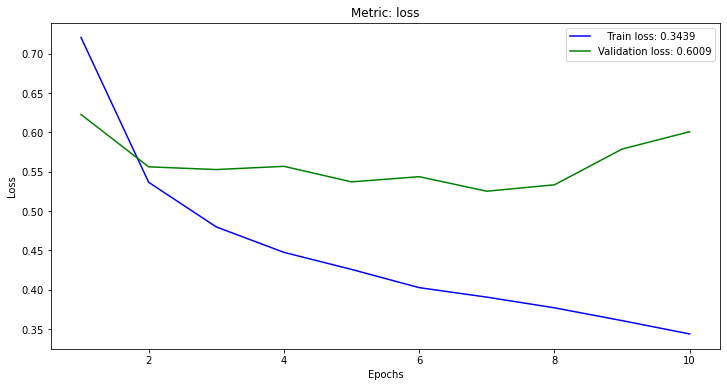

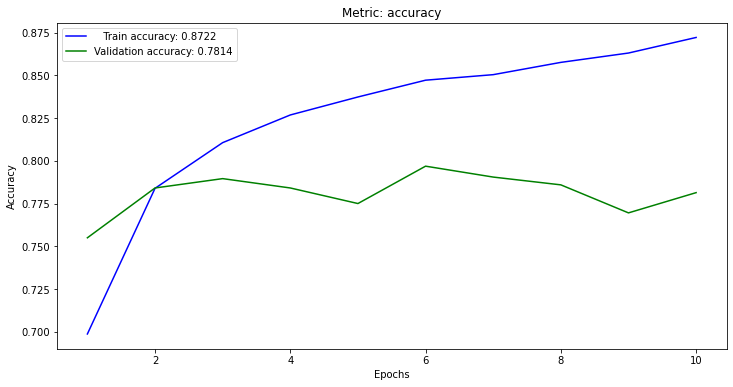

In [102]:
plot_history(history)

# Performance

In [103]:
performance = model.evaluate(
    X_test,
    Y_test,
    batch_size=24,
    verbose=1
)

print('\nScore Test Categorical Entropy:', performance[0])
print('\nScore Test Accuracy:', performance[1])

153/153 [==============================] - 1s 8ms/step - loss: 0.5927 - accuracy: 0.7858

Score Test Categorical Entropy: 0.592658519744873

Score Test Accuracy: 0.785792350769043


# PreProcessing for the CNN model

In [104]:
#"@user"
t_tweets = t_tweets.apply((lambda x: re.sub('@[\w]*',"",str(x))))

#URLs
t_tweets = t_tweets.apply((lambda x: re.sub('((www\.[\S]+)|(https?://[\S]+))',"",str(x))))

#Letters Only
t_tweets = t_tweets.apply((lambda x: re.sub('[^a-zA-Z]'," ",x)))

In [105]:
t_tweets.head()

0                                               said  
1      plus    added    commercial    experience   ...
2      today    must    mean    need    take    ano...
3      really    aggressive    blast    obnoxious  ...
4                      really    big    bad    thing  
Name: text, dtype: object

In [106]:

def rep_remover(replet):

    replet = re.sub(r'(.)\1+', r'\1\1', str(replet))

    return replet


t_tweets = np.vectorize(rep_remover)(t_tweets)
t_tweets

array(['  said  ', '  plus  added  commercial  experience  tacky  ',
       '  today  must  mean  need  take  another  trip  ', ...,
       '  please  bring  american  airline  blackberry  ',
       '  money  change  flight  answer  phone  suggestion  make  commitment  ',
       '  ppl  need  know  many  seat  next  flight  plz  put  u  standby  people  next  flight  '],
      dtype='<U152')

# Tokenization, encoding and sequences


In [107]:


le = LabelEncoder()
data['classes'] = le.fit_transform(data['airline_sentiment'])

In [108]:


length = []
for x in t_tweets:
    length.append(len(x.split()))
max(length)

21

In [109]:
maxlen=40
NUM_WORDS = 6000

In [110]:

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(t_tweets)





T = tokenizer.texts_to_sequences(t_tweets)


X = pad_sequences(T, maxlen=40)
X

array([[   0,    0,    0, ...,    0,    0,  122],
       [   0,    0,    0, ..., 1062,  104, 5133],
       [   0,    0,    0, ...,   62,   70,   96],
       ...,
       [   0,    0,    0, ...,  491,  323,   23],
       [   0,    0,    0, ...,  887,   42, 2035],
       [   0,    0,    0, ...,   66,   93,    1]], dtype=int32)

# Train & Test Split

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X,data['classes'], test_size = 0.2, random_state = 111)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11712, 40) (11712,)
(2928, 40) (2928,)


In [112]:
X.shape[1]

40

# Set Hyper-parameters

In [113]:

y_encoded = np_utils.to_categorical(Y_train)
test_y_endoded = np_utils.to_categorical(Y_test)






def model_cnn():
    model = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen),
                        Convolution1D(64, 2, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])






    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [114]:
model = model_cnn()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 32)            192000    
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 64)            4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                32025     
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [115]:
model = model_cnn()



history = model.fit(X_train, y_encoded, validation_data=(X_test, test_y_endoded), epochs=5, batch_size=100)

Epoch 1/5
118/118 [==============================] - 1s 7ms/step - loss: 0.8381 - accuracy: 0.6228 - val_loss: 0.7018 - val_accuracy: 0.6428
Epoch 2/5
118/118 [==============================] - 1s 6ms/step - loss: 0.6373 - accuracy: 0.7152 - val_loss: 0.6393 - val_accuracy: 0.7022
Epoch 3/5
118/118 [==============================] - 1s 6ms/step - loss: 0.5073 - accuracy: 0.7882 - val_loss: 0.5887 - val_accuracy: 0.7722
Epoch 4/5
118/118 [==============================] - 1s 10ms/step - loss: 0.3957 - accuracy: 0.8514 - val_loss: 0.5694 - val_accuracy: 0.7712
Epoch 5/5
118/118 [==============================] - 1s 6ms/step - loss: 0.3201 - accuracy: 0.8876 - val_loss: 0.6105 - val_accuracy: 0.7722


In [116]:
def plot_history(history):



    namesMetrics = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(namesMetrics):


        metric_values_train = history.history.get(metric, [])


        values_metric_val = history.history.get("val_{}".format(metric), [])


        epochs = range(1, len(metric_values_train) + 1)


        text_training = "   Train {}: {:.4f}".format(metric,
                                                        metric_values_train[-1])


        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_values_train,
                 'b',
                 label=text_training)


        if values_metric_val:
            text_validation = "Validation {}: {:.4f}".format(metric,
                                                             values_metric_val[-1])

            plt.plot(epochs,
                     values_metric_val,
                     'g',
                     label=text_validation)


        plt.title('Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

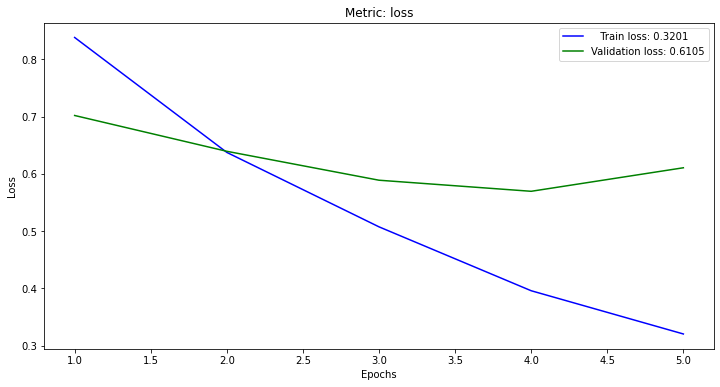

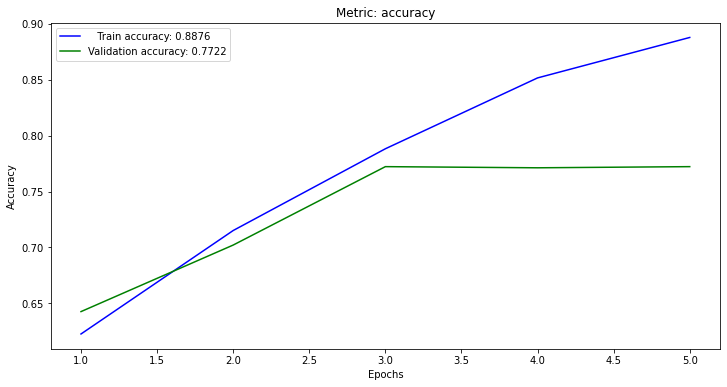

In [117]:
plot_history(history)

 ## Predictions

In [118]:
predictions = model.predict(X_test)

## Evaluation

In [119]:
print(metrics.classification_report(Y_test, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1844
           1       0.57      0.56      0.57       637
           2       0.73      0.69      0.71       447

    accuracy                           0.77      2928
   macro avg       0.72      0.71      0.71      2928
weighted avg       0.77      0.77      0.77      2928



In [120]:
metrics.accuracy_score(Y_test, np.argmax(predictions, axis=1))

0.7721994535519126

# Trying to improve the CNN model

In [121]:
def model_cnn():
    cnnModel = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen),
                        Convolution1D(128, 3, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])




    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [122]:
cnnModel = model_cnn()
cnnModel.fit(X_train, y_encoded, validation_data=(X_test, test_y_endoded), epochs=4, batch_size=100)

Epoch 1/4
118/118 [==============================] - 1s 8ms/step - loss: 0.2725 - accuracy: 0.9051 - val_loss: 0.6473 - val_accuracy: 0.7667
Epoch 2/4
118/118 [==============================] - 1s 6ms/step - loss: 0.2302 - accuracy: 0.9238 - val_loss: 0.7058 - val_accuracy: 0.7613
Epoch 3/4
118/118 [==============================] - 1s 6ms/step - loss: 0.2006 - accuracy: 0.9325 - val_loss: 0.7835 - val_accuracy: 0.7565
Epoch 4/4
118/118 [==============================] - 1s 6ms/step - loss: 0.1706 - accuracy: 0.9447 - val_loss: 0.8615 - val_accuracy: 0.7490


### As we can see, there was no improvement

In [123]:
predictions_2 = cnnModel.predict(X_test)

In [124]:
metrics.accuracy_score(Y_test, np.argmax(predictions_2, axis=1))

0.7489754098360656

In [125]:
end = time.time()
print(end - start)

426.31237626075745
